## Digits

In [1]:
from math import *
import pandas as pd
import numpy as np
import tensorflow as tf
import warnings
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import Imputer, StandardScaler
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy import stats

import keras
from keras.models import Sequential, model_from_yaml, Model
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Convolution2D, Flatten, MaxPooling2D
from keras.optimizers import Adam
from keras import backend as K
from tensorflow.python.client import device_lib
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


import lightgbm as lgb
import seaborn as sns
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
warnings.filterwarnings('ignore')

print(device_lib.list_local_devices())
config = tf.ConfigProto(device_count={"CPU": 1, "GPU" : 1})
session = tf.Session(config=config)
K.set_session(session)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3019038779129731625
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4945621811
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5544155947401095023
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:08:00.0, compute capability: 6.1"
]


In [2]:
res = pd.read_csv(r"c:\work\dataset\digits\test.csv", ",")
train = pd.read_csv(r"c:\work\dataset\digits\train.csv", ",")
dep = train.iloc[:, 0]
indep = train.iloc[:, 1:].values
res = res.values
result = pd.DataFrame(pd.Series(range(1,28001), name="ImageId"))
dep_cat = to_categorical(dep)

indep = indep.reshape(indep.shape[0], 28, 28, 1).astype('float32')/255
res = res.reshape(res.shape[0], 28, 28, 1).astype('float32')/255
print(indep.shape, res.shape)

(42000, 28, 28, 1) (28000, 28, 28, 1)


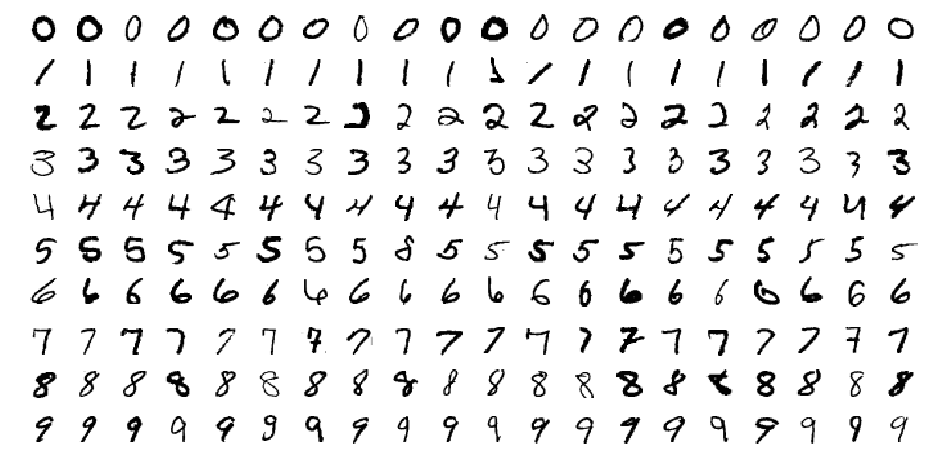

In [3]:
fig, ax = plt.subplots(10, 20, figsize=(16, 8))
for j in range (0, 10):
    index = dep[dep==j].index
    for i in range (0, 20):
        ax[j, i].axis("off")
        ax[j, i].imshow(1-indep[index[i],:,:,0], cmap=plt.get_cmap('gray'))
plt.show()

# Keras CNN

In [4]:
'''
with tf.device('/device:GPU:0'):
    model =[]
    for i in range (0, 11):
        image_gen = ImageDataGenerator(zoom_range = 0.15, rotation_range=15, shear_range=.15, height_shift_range=0.15, width_shift_range=0.15)
        image_gen.fit(indep, augment=True)
        gs1 = Sequential()
        gs1.add(Convolution2D(128, (5,5), input_shape=(28, 28, 1), activation='relu'))
        gs1.add(Dropout(0.2))
        gs1.add(BatchNormalization())
        gs1.add(Convolution2D(128, (5,5), activation='relu'))
        gs1.add(Dropout(0.2))
        gs1.add(BatchNormalization())
        gs1.add(MaxPooling2D())
        gs1.add(Convolution2D(64, (3,3), activation='relu'))
        gs1.add(Dropout(0.2))
        gs1.add(BatchNormalization())
        gs1.add(MaxPooling2D())
        gs1.add(Flatten())
        gs1.add(Dense(256, activation='relu'))
        gs1.add(Dropout(0.4))
        gs1.add(BatchNormalization())
        gs1.add(Dense(64, activation='relu'))
        gs1.add(Dropout(0.3))
        gs1.add(BatchNormalization())
        gs1.add(Dense(10, activation='softmax'))
        gs1.compile(Adam(decay=0.001/200), loss='categorical_crossentropy', metrics=['accuracy'])

        gs1.fit_generator(image_gen.flow(indep, dep_cat, batch_size=32), 
                      epochs=200, verbose=2,
                     steps_per_epoch=indep.shape[0]/32)
        model.append(gs1)
   ''';     

In [5]:
"""
from keras.models import model_from_yaml
for i in range(0,11):
    model_yaml = model[i].to_yaml()
    with open(r"c:/work/dataset/digits/model{0}.yaml".format(i+11), "w") as yaml_file:
        yaml_file.write(model_yaml)
    model[i].save_weights(r"c:/work/dataset/digits/model{0}.h5".format(i))
    """;

In [6]:
model =[]
for i in range(0,31):
    with open(r"c:/work/dataset/digits/model{0}.yaml".format(i), "r") as yaml_file:
        m = model_from_yaml(yaml_file.read())
        m.load_weights(r"c:/work/dataset/digits/model{0}.h5".format(i))
        model.append(m)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
data = pd.DataFrame()
lgbm_inputs = pd.DataFrame()
lgbm_res = pd.DataFrame()
for j in range(0,31):
    partial = Model(inputs=model[j].input, outputs=model[j].layers[15].output)
    if (j==0):
        lgbm_inputs = pd.DataFrame(partial.predict(indep))
        lgbm_res = pd.DataFrame(partial.predict(res))
    else:
        lgbm_inputs = pd.concat([lgbm_inputs, pd.DataFrame(partial.predict(indep))], axis=1)
        lgbm_res = pd.concat([lgbm_res, pd.DataFrame(partial.predict(res))], axis=1)
    print (j)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [15]:
lgbm_inputs.shape

(42000, 1984)

In [24]:
for i in range (0, 11):
    indep_train, indep_test, dep_train, dep_test = train_test_split(lgbm_inputs, dep, test_size=0.10)
    gs2 = lgb.LGBMClassifier(max_depth = 12,
                             learning_rate = 0.01, 
                             n_estimators = 5000, reg_alpha = 1.1, 
                             n_jobs = 12)
    gs2.fit(indep_train, dep_train, eval_set=[(indep_test, dep_test)], eval_metric='multi_logloss', verbose=False, early_stopping_rounds=50);
    g = gs2.predict(lgbm_res)
    a = accuracy_score(dep_test, gs2.predict(indep_test))
    data[i] = g
    res_test = gs2.predict(lgbm_inputs)
    un = dep[dep!=res_test]
    n = len(un)
    print(j, i, a, float(np.sum(res_test == dep))/dep.shape[0], n)

g = stats.mode(data, axis=1)[0]
result["Label"] = g.astype(np.int)
result.to_csv(r"c:/work/dataset/digits/mnist_ensemble_lgbm.csv", ",", index=None)

30 0 0.9997619047619047 0.9999761904761905 1
30 1 0.9995238095238095 0.9999523809523809 2
30 2 1.0 1.0 0
30 3 0.9997619047619047 0.9999761904761905 1
30 4 0.9997619047619047 0.9999761904761905 1
30 5 0.9990476190476191 0.9999047619047619 4
30 6 1.0 1.0 0
30 7 0.9992857142857143 0.9999285714285714 3
30 8 0.9997619047619047 0.9999761904761905 1
30 9 1.0 1.0 0
30 10 0.9997619047619047 0.9999761904761905 1
